Naive Bayes is an extremely simple classification scheme that often works amazingly well in practice.  We'll apply it to the [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), which we saw in Lecture 1.  First, let's import the dataset from sklearn and plot histograms of each class.

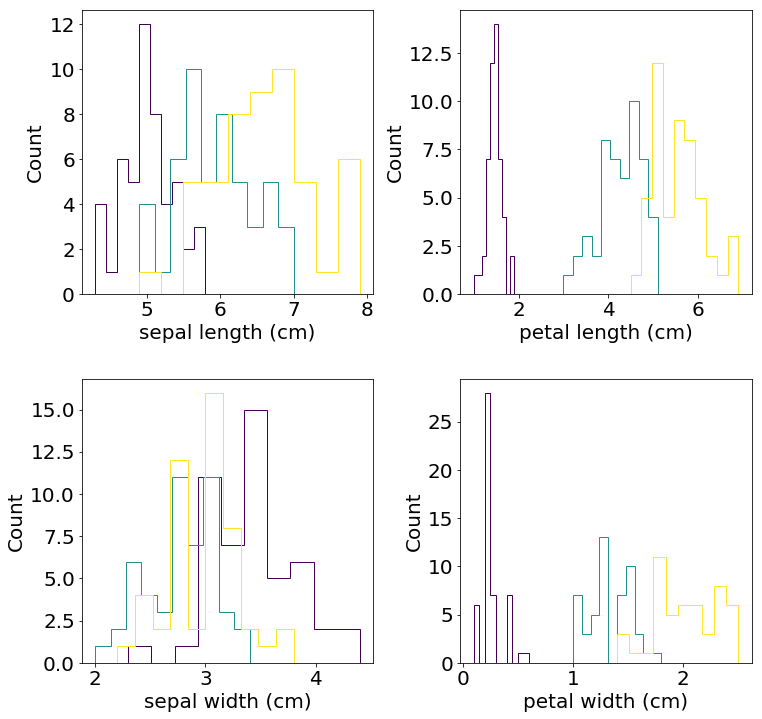

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [12,12]
mpl.rcParams['font.size'] = 20
import numpy as np

from sklearn import datasets

# Load the dataset
iris = datasets.load_iris()
X = iris.data    # n x m matrix of features 
Y = iris.target  # n vector of classes

classes = [0,1,2] #Numeric class identifiers: 0 -> Setosa, 1-> Versicolor, 2-> Virginica
N = len(classes) # The number of classes
m = X.shape[0]   # The number of data points
n = X.shape[1]   # The number of features

# Colors for each class
colors = [[0.267004, 0.004874, 0.329415, 1.      ],
          [0.127568, 0.566949, 0.550556, 1.      ],
          [0.993248, 0.906157, 0.143936, 1.      ]]
names = ['Setosa','Versicolor','Virginica']

# Plot histograms of all the features
fig,axs = plt.subplots(nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.3,wspace=0.3)
for i in range(4):
    p = i%2
    q = i//2
    axs[p,q].hist(X[Y==0,i],histtype='step',color=colors[0])
    axs[p,q].hist(X[Y==1,i],histtype='step',color=colors[1])
    axs[p,q].hist(X[Y==2,i],histtype='step',color=colors[2])
    axs[p,q].set_xlabel(iris.feature_names[i])
    axs[p,q].set_ylabel('Count')

plt.show()

Our goal is to take a new set of iris measurements and output a class.  The method works in a two step processs: First, for a set of classes $C_k \in \{C_1,C_2,\ldots,C_N\}$, where $N$ is the number of possible class labels (3 in this case), use Bayes' rule to generate a probability that a new example with a set of features $x$ belongs to each class, given a set of training data $D=(X,Y)$.  In step two, assign the class label with the highest probability to that data instance.  For each class $C_k$, we can use Bayes' rule to determine the probability:
$$ 
P(C_k|x,D) \propto P(x|C_k) P(C_k|D).
$$

This equation implies that we have to compute the joint probability of $x$, where there could be some complicated correlations between features.  We can simplify this model by assuming that all of the features are independent, or
$$ P(x|D,C_k) \approx \prod_{j=1}^n P(x|D,C_k), $$
where $n$ is the number of features in the dataset.  This is the so-called *naive Bayes* assumption, naive because it assumes no correlation between features.  This leads to the simpler model:
$$
P(C_k|x,D) \propto P(C_k|D) \prod_{j=1}^n P(x_j|D,C_k).
$$

Now, we need to specify the distributions for the class prior $P(C_k|D)$ and class likelihoods $P(x|D,C_k)$.  We can model the prior probability as a Bernoulli distribution 
$$P(C=C_k|D) = \eta_k, $$
where $\eta_k$ is the probability that we would label the new example as $C_k$, before having seen any of the values in x.  There are different options here.  We could say that all classes are equally likely, so $\eta=1/N$.  A more common practice is to estimate $\eta$ as the maximum likelihood value from the training data $D$, which for a Bernoulli distribution is 
$$
\eta_k = \frac{\sum_{i=1}^m [C = C_k]}{m},
$$
or the total proportion of the training data where the label is $C_k$.  Note the use of the [Iverson Bracket](https://en.wikipedia.org/wiki/Iverson_bracket) in the above definition.

In [50]:
etas = np.zeros((N))
for C_k in [0,1,2]:
    etas[C_k] = len(Y[Y==C_k])/len(Y)
print(etas) #About fifty/fifty : a balanced dataset

[0.33333333 0.33333333 0.33333333]


For the likelihood, since we're considering continuous features, it makes sense to use a continous likelihood function.  While there are many options, a normal distribution should do the trick, which is to say that.
$$
P(x_j|C_k,D) = \frac{1}{\sqrt{2\pi \sigma_k^2}} \exp -\frac{(x_j-\mu_k)^2}{2\sigma_k^2}
$$
However, before we can use this, we need to use the training data to estimate the parameters of this normal distribution.  We can use maximum likelihood estimation to do this.  Once again, maximum likelihood estimation finds the parameters which maximize the likelihood over all pairs of class labels and features, or
$$
\mu_k = \mathrm{argmax}_{\mu_k} \prod_{i=1}^m \frac{1}{\sqrt{2\pi \sigma_k^2}} \exp \left[-\frac{(X_i-\mu_k)^2} {2\sigma_k^2} [Y_i=C_k] \right].
$$
It is much easier to work with the log-likelihood.  A log-transformation maintains the position of the maximum so the above can equivalently be written as 
$$
\mu_k = \mathrm{argmax}_{\mu_k} \sum_{i=1}^m \left[-\frac{(X_i-\mu_k)^2} {2\sigma_k^2} [Y_i=C_k] \right] - \frac{m}{2}\ln 2\pi\sigma_k^2.
$$
Doing the normal thing of taking the derivative of the right hand side and setting equal to zero gives the estimator
$$
\mu_k = \frac{\sum_{i=1}^m X_i [Y_i=C_k]}{\sum_{i=1}^m [Y_i=C_k]},
$$
which is simply the sample mean for all the training data for which the class is $C_k$.  We can do an equivalent procedure for $\sigma^2$, the variance:
$$
\sigma^2_k = \frac{\sum_{i=1}^m (X_i - \mu_k) [Y_i=C_k]}{\sum_{i=1}^m [Y_i=C_k]},
$$
which is the sample variance.

In [51]:
mus = np.zeros((N,n))
variances = np.zeros((N,n))
for C_k in [0,1,2]:
    for i in range(n):
        mus[C_k,i] = sum(X[Y==C_k,i])/sum(Y==C_k)
        variances[C_k,i] = sum((X[Y==C_k,i] - mus[C_k,i])**2)/sum(Y==C_k)
print(mus)
print(variances)

[[5.006 3.418 1.464 0.244]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]
[[0.121764 0.142276 0.029504 0.011264]
 [0.261104 0.0965   0.2164   0.038324]
 [0.396256 0.101924 0.298496 0.073924]]


What do these distributions look like?  We can plot them over the histogram of features to see.

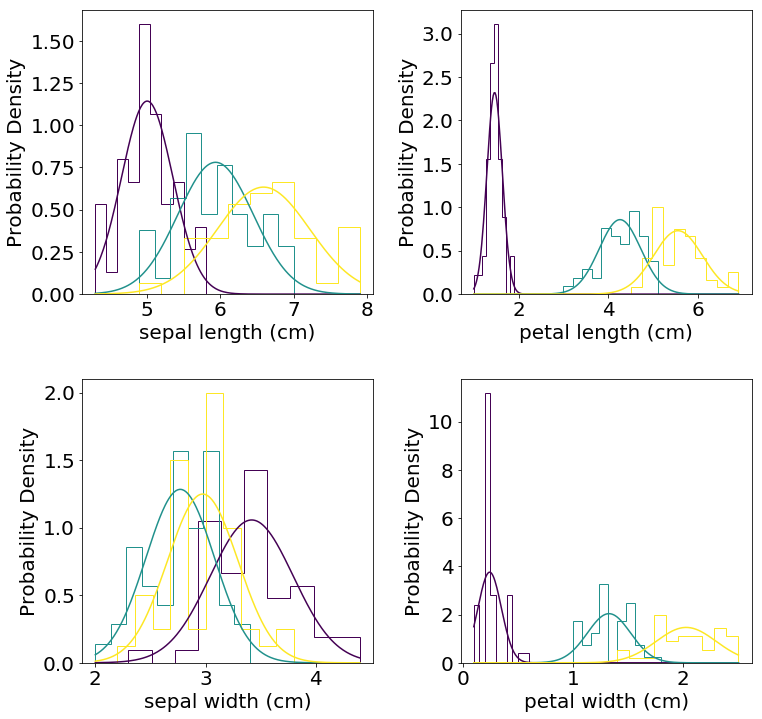

In [52]:
# Plot histograms of all the features
fig,axs = plt.subplots(nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.3,wspace=0.3)
for i in range(4):
    p = i%2
    q = i//2
    axs[p,q].hist(X[Y==0,i],histtype='step',density=True,color=colors[0])
    axs[p,q].hist(X[Y==1,i],histtype='step',density=True,color=colors[1])
    axs[p,q].hist(X[Y==2,i],histtype='step',density=True,color=colors[2])
    axs[p,q].set_xlabel(iris.feature_names[i])
    axs[p,q].set_ylabel('Probability Density')
    xx = np.linspace(X[:,i].min(),X[:,i].max(),300)
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[0,i])*np.exp(-(xx-mus[0,i])**2/(2*variances[0,i])),color=colors[0])
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[1,i])*np.exp(-(xx-mus[1,i])**2/(2*variances[1,i])),color=colors[1])
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[2,i])*np.exp(-(xx-mus[2,i])**2/(2*variances[2,i])),color=colors[2])
    
plt.show()

Now we have completely trained the model, by fitting a normal distribution to the data for each class.  Now, we can just evaluate the probability of each example according to our formula for the posterior distribution
$$ 
P(C_k|x,D) \propto P(x|C_k) P(C_k|D).
$$
for each class.  Let's consider the example 
$$
x = \{7.65, 3.3 , 6.25, 1.95\},
$$
which plots as 

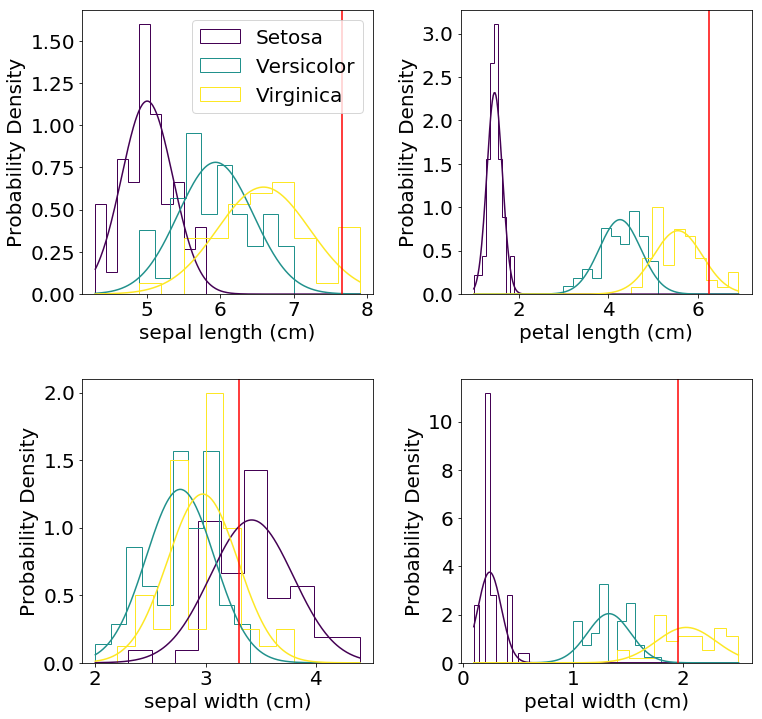

In [53]:
# Plot histograms of all the features
x = np.array([7.65, 3.3 , 6.25, 1.95])
fig,axs = plt.subplots(nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.3,wspace=0.3)
for i in range(4):
    p = i%2
    q = i//2
    axs[p,q].hist(X[Y==0,i],histtype='step',density=True,color=colors[0],label=names[0])
    axs[p,q].hist(X[Y==1,i],histtype='step',density=True,color=colors[1],label=names[1])
    axs[p,q].hist(X[Y==2,i],histtype='step',density=True,color=colors[2],label=names[2])
    axs[p,q].set_xlabel(iris.feature_names[i])
    axs[p,q].set_ylabel('Probability Density')
    xx = np.linspace(X[:,i].min(),X[:,i].max(),300)
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[0,i])*np.exp(-(xx-mus[0,i])**2/(2*variances[0,i])),color=colors[0])
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[1,i])*np.exp(-(xx-mus[1,i])**2/(2*variances[1,i])),color=colors[1])
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[2,i])*np.exp(-(xx-mus[2,i])**2/(2*variances[2,i])),color=colors[2])
    axs[p,q].axvline(x[i], color='red')
    if i==0: axs[p,q].legend()
plt.show()

It's only consistent with 1 of the 3 classes in all cases.  Let's see how that plays out mathematically:

In [54]:
class_posterior = np.zeros((N))

for C_k in range(N):
    prior = etas[C_k]
    class_posterior[C_k]=prior
    for i in range(n):
        likelihood = 1./np.sqrt(2*np.pi*variances[C_k,i])*np.exp(-(x[i] - mus[C_k,i])**2/(2*variances[C_k,i]))
        class_posterior[C_k] *= likelihood
# Normalize by the evidence
class_posterior/=np.sum(class_posterior)

print(class_posterior)

[1.34989547e-235 1.88581438e-008 9.99999981e-001]


Clearly, the probability favors the third class, which is Virginica.  This is consistent with the plot above.  How about a somewhat more ambiguous example?

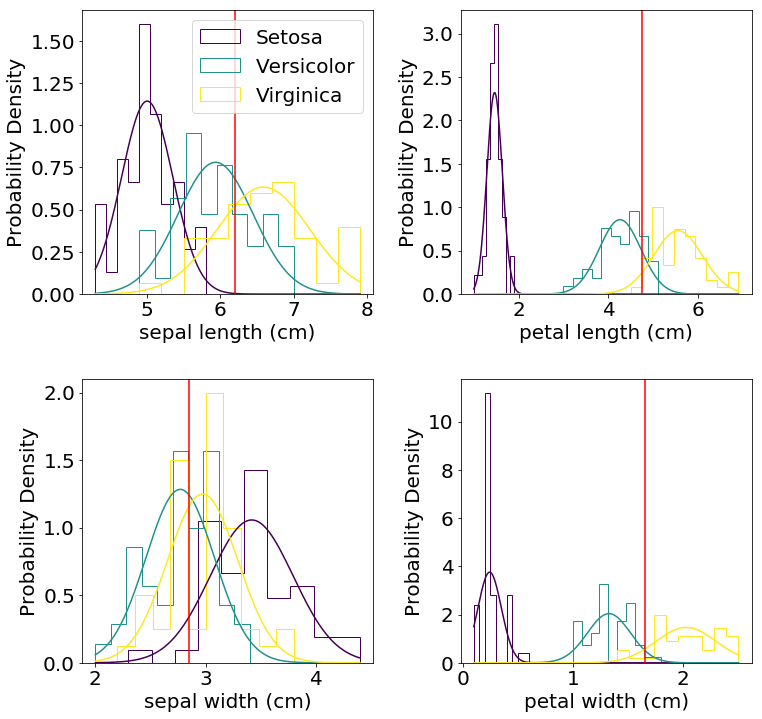

In [55]:
# Plot histograms of all the features
x = np.array([6.2 , 2.85, 4.75, 1.65])
fig,axs = plt.subplots(nrows=2,ncols=2)
fig.subplots_adjust(hspace=0.3,wspace=0.3)
for i in range(4):
    p = i%2
    q = i//2
    axs[p,q].hist(X[Y==0,i],histtype='step',density=True,color=colors[0],label=names[0])
    axs[p,q].hist(X[Y==1,i],histtype='step',density=True,color=colors[1],label=names[1])
    axs[p,q].hist(X[Y==2,i],histtype='step',density=True,color=colors[2],label=names[2])
    axs[p,q].set_xlabel(iris.feature_names[i])
    axs[p,q].set_ylabel('Probability Density')
    xx = np.linspace(X[:,i].min(),X[:,i].max(),300)
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[0,i])*np.exp(-(xx-mus[0,i])**2/(2*variances[0,i])),color=colors[0])
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[1,i])*np.exp(-(xx-mus[1,i])**2/(2*variances[1,i])),color=colors[1])
    axs[p,q].plot(xx,1./np.sqrt(2*np.pi*variances[2,i])*np.exp(-(xx-mus[2,i])**2/(2*variances[2,i])),color=colors[2])
    axs[p,q].axvline(x[i], color='red')
    if i==0: axs[p,q].legend()
plt.show()


Once again, we compute posterior probabilities

In [56]:
class_posterior = np.zeros((N))

for C_k in range(N):
    prior = etas[C_k]
    class_posterior[C_k]=prior
    for i in range(n):
        likelihood = 1./np.sqrt(2*np.pi*variances[C_k,i])*np.exp(-(x[i] - mus[C_k,i])**2/(2*variances[C_k,i]))
        class_posterior[C_k] *= likelihood
# Normalize by the evidence
class_posterior/=np.sum(class_posterior)

print(class_posterior)

[8.48769059e-120 7.17735748e-001 2.82264252e-001]


Unsurprisingly, for this edge case, we find non-negligible probabilities for both Versicolor and Virginica (while still getting a nealy zero probability for Setosa).  Just to get a better intuitive sense for what gets misclassified, let's run the classifier for all of the training data, and highlight the ones that get predicted wrong.  This time, we'll plot all possible permutations of pairs of variables to get a sense for whether the correlations between variables (which we're ignoring) might be causing problems.  

In [57]:
class_posterior = np.zeros((m,N))

for j in range(m):
    x = X[j]
    for C_k in range(N):
        prior = etas[C_k]
        class_posterior[j,C_k]=prior
        for i in range(n):
            likelihood = 1./np.sqrt(2*np.pi*variances[C_k,i])*np.exp(-(x[i] - mus[C_k,i])**2/(2*variances[C_k,i]))
            class_posterior[j,C_k] *= likelihood
    # Normalize by the evidence
    class_posterior[j]/=np.sum(class_posterior[j])


prediction = np.argmax(class_posterior,axis=1)
print (prediction)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


[]

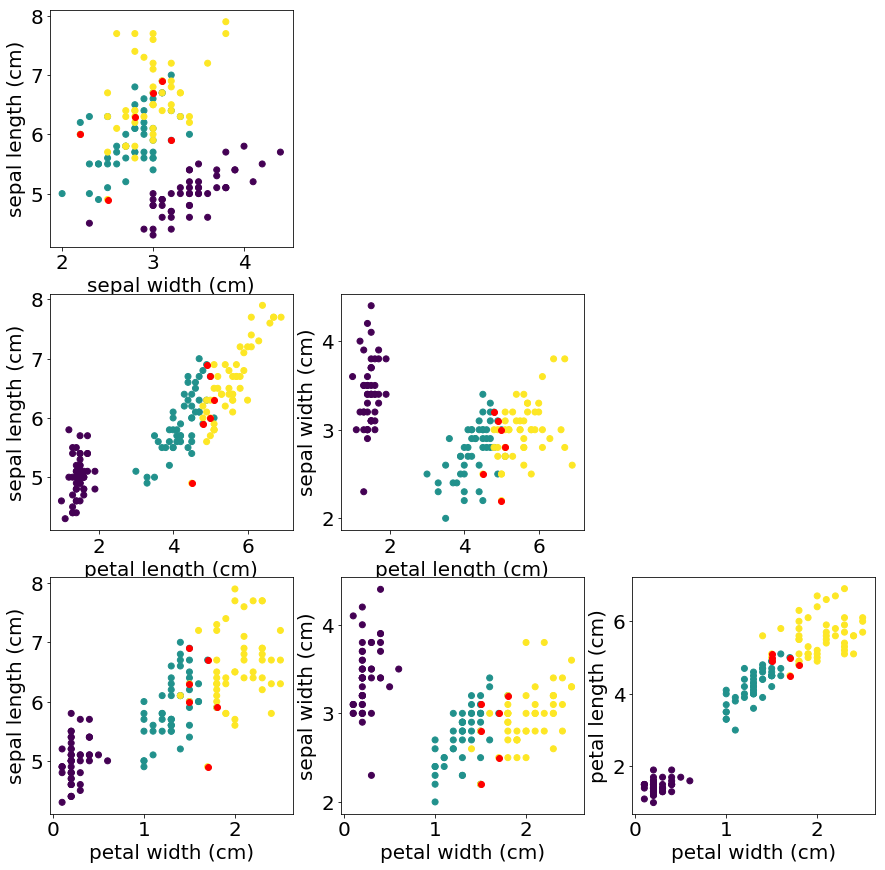

In [58]:
mpl.rcParams['figure.figsize'] = [20,20]

# 2D plots of all possible permutations of 2 features out of 4 produces 4 choose 2 plots
fig,axs = plt.subplots(nrows=4,ncols=4)
for i in range(4):
    for j in range(4):
        if i>j:
            axs[i,j].scatter(X[:,i],X[:,j],c=Y)
            axs[i,j].set_xlabel(iris['feature_names'][i])
            axs[i,j].set_ylabel(iris['feature_names'][j])
            axs[i,j].scatter(X[Y!=prediction,i],X[Y!=prediction,j],c='red')
        else: # delete redundant plots
            fig.delaxes(axs[i,j])
plt.plot()